# RAG over complex PDF


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [5]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7f060028e3b0>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f05d33435e0>])

### Embedding 모델 선택

In [7]:
from langchain.embeddings import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [9]:
import boto3
from utils.ssm import parameter_store

In [10]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [11]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [12]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [13]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: kb_complex_pdf


### OpenSearch Client 생성

In [14]:
from utils.opensearch import opensearch_utils

In [15]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [16]:
from utils.rag import qa_chain_complex_pdf
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [17]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document = False, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_pdf=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [18]:
system_prompt = prompt_repo.get_system_prompt()

In [19]:
qa = qa_chain_complex_pdf(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    get_context=True,
    verbose=False
)

이 그래프는 기준자산가격과 세전수익률 간의 관계를 보여줍니다. 가로축은 기준자산가격(원금 대비 적정기준가격, %)을 나타내고, 세로축은 세전수익률(%)을 나타냅니다. 원금부정 지점은 100%이며, 이때 수익률은 0%입니다. 기준자산가격이 130%일 때 세전수익률은 약 21%입니다. 상승률 70%에 해당하는 곡선이 그려져 있어 기준자산가격과 수익률 간의 관계를 명확히 보여줍니다. 이 그래프를 통해 투자 수익률과 위험 수준 간의 상관관계를 파악할 수 있습니다.
-----------------------------------------------
1. Category: Image, Chunk: 228 Characters
-----------------------------------------------


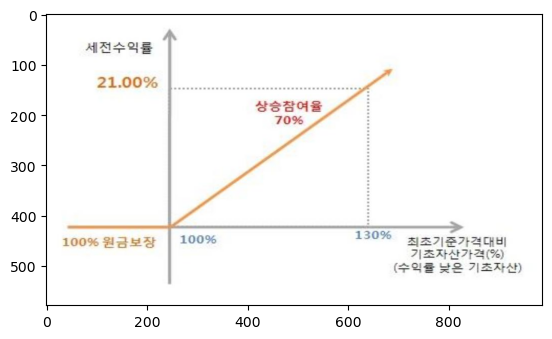

이 이미지는 가로축에 원금 대비 적정기준가격(%)을, 세로축에 서전수익률을 나타내는 그래프입니다. 원금부정 지점은 100%이며, 상승곡선은 70%의 상승률에 해당하는 약 21%의
서전수익률을 보여주고 있습니다. 이는 적정기준가격이 130%에 이르면 투자자들이 원금 회수와 함께 21%의 수익을 얻을 수 있음을 의미합니다. 이 그래프는 투자 수익률과 위험 수준
간의 관계를 보여주는 것으로 해석할 수 있습니다.
metadata:
 {'img_path': './fig/figure-3-3.jpg', 'category': 'Image', 'image_base64': '', 'id':
'128c2189-5fa2-4bf2-abc3-f2e39b2a4bef', 'origin_image': ''}

-----------------------------------------------
2. Category: CompositeElement, Chunk: 436 Characters
-----------------------------------------------
□ 본 설명서는 이 상품의 중요내용만을 선별하여 요약한 것이므로 이 설명서에만 의존하지 마시고 투자설명서 등 세부 설명자료를 반드시 확인하신 후 청약하시기 바랍니다. [ 설명직원
확인 ] • 미래에셋증권 ( )지점 ( ) (은)는 위 내용에 대하여 고객 에게 설명하고, 이 설명서를 교부하였습니다.(☎ - - , 홈페이지
http://www.miraeassetaccount.com). 2011. . . (인) 이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여 금융상품의
핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다. ※ 손익구조 그래프 수익률 그래프 HE=HE 21.00%
4STEHE 70% 130% m=oz=spzgpy| IR AT (%) (B 22 7| =X 100% HSEF
metadata:
 {'source': './data

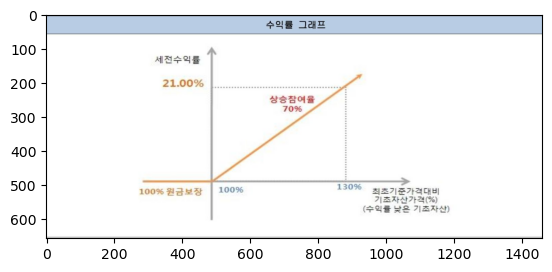

이 그래프는 기준자산가격과 세전수익률 간의 관계를 보여줍니다. 가로축은 기준자산가격(%)을 나타내고, 세로축은 세전수익률(%)을 나타냅니다. 기준자산가격이 100%일 때
세전수익률은 0%입니다. 기준자산가격이 130%일 때 세전수익률은 약 21%입니다. 또한 상승캡여율 70%선이 그려져 있어 기준자산가격과 수익률 간의 관계를 잘 보여줍니다.
metadata:
 {'img_path': './fig/figure-3-2.jpg', 'category': 'Image', 'image_base64': '', 'id':
'8119cff6-bb2c-4ee7-8683-7b486e4d351c', 'origin_image': ''}

-----------------------------------------------
4. Category: CompositeElement, Chunk: 436 Characters
-----------------------------------------------
투자수익 사례 : 1 억원을 투자한 경우 ○ 만기상환 ① : 두 기초자산의 만기평가가격이 KOSPI200 은 300pt, 금가격지수는 $1,650 인 경우 ⇒ 1 억원 700 만원
지급 = 1 억원×[100%+{(1,650-1,500)/1,500×70%}] (만기수익률이 낮은 금가격지수 기준) ○ 만기상환 ② : 두 기초자산의 만기평가가격이 KOSPI200
은 300pt, 금가격지수는 $1,350 인 경우 ⇒ 1 억원 지급(100% 원금보장) 이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여 금융상품의
핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다. 최대 투자손실 발생사례 : 1 억원을 투자한 경우 본 상품은
원금보장형으로 최대 투자손실 발생사례가 존재하지 않습니다. 6| 6
metadata:
 {'source': './data/complex_pdf/sample.pdf', 'filetype':

In [20]:
query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15
query = "수익률 그래프 설명해줘"

response, contexts = qa.invoke(
    query = query
)

show_context_used(contexts)

### Parameter updates

In [21]:
opensearch_hybrid_retriever.update_search_params(
    k=8,
    minimum_should_match=0,
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [22]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

query = "기준 자산가치가 100% 일 때 수익률은?"
#query = "수익률 그래프 설명해줘"
#query = "수익률 그래프 설명해줘"

In [23]:
response, contexts = qa.invoke(
    query = query
)

기준자산가격이 100%일 때 수익률은 0%입니다. 그래프에서 가로축 100%에 해당하는 세로축 값이 0%임을 확인할 수 있습니다.

##################################
query:  기준 자산가치가 100% 일 때 수익률은?
##################################


### Answer ###
기준자산가격이 100%일 때 수익률은 0%입니다. 그래프에서 가로축 100%에 해당하는 세로축 값이 0%임을 확인할 수 있습니다.


### Contexts ###

-----------------------------------------------
1. Category: CompositeElement, Chunk: 436 Characters
-----------------------------------------------
투자수익 사례 : 1 억원을 투자한 경우 ○ 만기상환 ① : 두 기초자산의 만기평가가격이 KOSPI200 은 300pt, 금가격지수는 $1,650 인 경우 ⇒ 1 억원 700 만원
지급 = 1 억원×[100%+{(1,650-1,500)/1,500×70%}] (만기수익률이 낮은 금가격지수 기준) ○ 만기상환 ② : 두 기초자산의 만기평가가격이 KOSPI200
은 300pt, 금가격지수는 $1,350 인 경우 ⇒ 1 억원 지급(100% 원금보장) 이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여 금융상품의
핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다. 최대 투자손실 발생사례 : 1 억원을 투자한 경우 본 상품은
원금보장형으로 최대 투자손실 발생사례가 존재하지 않습니다. 6| 6
metadata:
 {'source': './data/complex_pdf/sample.pdf', 'filetype': 'application/pdf', 'languages': ['eng'],
'last_modified': '2024-03-17T06:02:18', 'page_number': 1, 'file_directory': './data/complex_pd

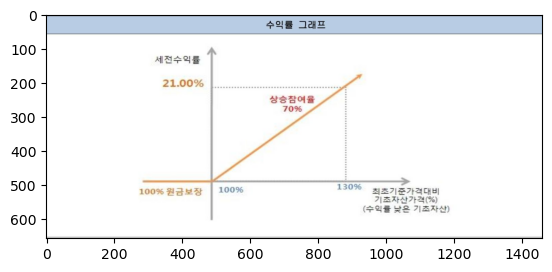

이 그래프는 기준자산가격과 세전수익률 간의 관계를 보여줍니다. 가로축은 기준자산가격(%)을 나타내고, 세로축은 세전수익률(%)을 나타냅니다. 기준자산가격이 100%일 때
세전수익률은 0%입니다. 기준자산가격이 130%일 때 세전수익률은 약 21%입니다. 또한 상승캡여율 70%선이 그려져 있어 기준자산가격과 수익률 간의 관계를 잘 보여줍니다.
metadata:
 {'img_path': './fig/figure-3-2.jpg', 'category': 'Image', 'image_base64': '', 'id':
'8119cff6-bb2c-4ee7-8683-7b486e4d351c', 'origin_image': ''}

-----------------------------------------------
3. Category: Image, Chunk: 228 Characters
-----------------------------------------------


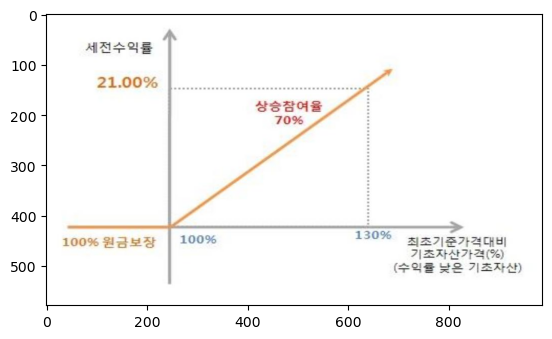

이 이미지는 가로축에 원금 대비 적정기준가격(%)을, 세로축에 서전수익률을 나타내는 그래프입니다. 원금부정 지점은 100%이며, 상승곡선은 70%의 상승률에 해당하는 약 21%의
서전수익률을 보여주고 있습니다. 이는 적정기준가격이 130%에 이르면 투자자들이 원금 회수와 함께 21%의 수익을 얻을 수 있음을 의미합니다. 이 그래프는 투자 수익률과 위험 수준
간의 관계를 보여주는 것으로 해석할 수 있습니다.
metadata:
 {'img_path': './fig/figure-3-3.jpg', 'category': 'Image', 'image_base64': '', 'id':
'128c2189-5fa2-4bf2-abc3-f2e39b2a4bef', 'origin_image': ''}

-----------------------------------------------
4. Category: Table, Chunk: 174 Characters
-----------------------------------------------
이 표는 만기상환금액의 계산 방식을 설명하고 있습니다. 만기평가가격이 최초기준가격의 100% 이상일 경우, 만기수익률이 낮은 기초자산의 기준가격을 최초기준가격으로 나누고 70%를
곱해 상환금액을 결정합니다. 반면 만기평가가격이 최초기준가격의 100% 미만일 경우, 총액면금액의 100%를 상환금액으로 지급합니다.
metadata:
 {'source': './data/complex_pdf/sample.pdf', 'detection_class_prob': 0.7832361459732056,
'coordinates': {'points': [[80.69361877441406, 1239.41259765625], [80.69361877441406,
1504.050048828125], [1566.467041015625, 1504.050048828125], [1566.467041015625, 1239.41259765625]],
'system': 'PixelS

In [24]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts)